In [155]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from IPython.display import Image
from IPython.core.display import HTML 

In [156]:
#metaparametrs
epochs = 5 # more epochs lead to increased accuracy
batch_size = 200 #CNN learns better with this butch size
validation_batch_size = 500
learning_rate = 0.0001
import scipy.io

In [157]:
def load_svhn(path):
    
    def normalize(array):
        mean = np.mean(array)
        st = np.std(array)
        array = (array-mean)/st
        return array
    
    matfile = scipy.io.loadmat(path)
    images = matfile['X']
    images = normalize(images)
    images = np.expand_dims(images,0)
    images = np.swapaxes(images, 0,4)
    images = np.squeeze(images)
    labels = matfile['y']
    labels = np.squeeze(labels)
    
    validation_images = images[:1000,:,:,:]
    training_images = images[1000:5000,:,:,:]
    validation_labels = labels[:1000]
    training_labels = labels[1000:5000]
    
    return training_images, training_labels, validation_images, validation_labels


training_data, training_labels, validation_data, validation_labels = load_svhn('../train_32x32.mat')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

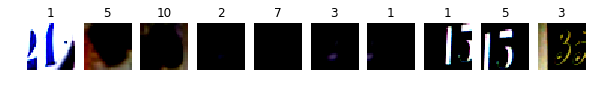

In [158]:
#We want to investigate the normilized data. To see actual names of category we set title to "label_to_word"
# We can see that images differ from original ones. 
fig, ax = plt.subplots(1,10,figsize=(10,10))

for i in range(10):
    ax[i].imshow(training_data[i])
    ax[i].axis('off')
    ax[i].set_title(training_labels[i]) # we take i_th training label and use it as a key of the dictionary

In [159]:
tf.reset_default_graph()
# Getting data
training_dataset = tf.data.Dataset.from_tensor_slices((training_data, training_labels))
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_data, validation_labels))

# This allows us to directly define batchsize we want to use.
training_dataset = training_dataset.batch(batch_size)
validation_dataset = validation_dataset.batch(validation_batch_size)

# Shuffle the training data in each epoch.
training_dataset = training_dataset.shuffle(buffer_size=4, reshuffle_each_iteration=True)
# Shuffle the training data in each epoch.
#training_dataset = training_dataset.shuffle(buffer_size=4, reshuffle_each_iteration=True)

In [160]:
# Next we need an iterator which will allow us to iterate throught the dataset.
iterator = tf.data.Iterator.from_structure(training_dataset.output_types, training_dataset.output_shapes)

next_batch = iterator.get_next()

# And we prepare initializer
training_init_op = iterator.make_initializer(training_dataset)
validation_init_op = iterator.make_initializer(validation_dataset)

In [161]:
# Get input for Network

input_data  = next_batch[0]
input_data = tf.cast(input_data, tf.float32)

labels = next_batch[1]
labels = tf.cast(labels, tf.int64)
labels_one_hot = tf.one_hot(labels,10)

In [162]:
# We want to use dropout technique which allows to redce overfitting problem. 
#We will dumpen 50% of neurons during forward step, so not all of them will learn on each batch. BUT! We do not want to
#use dropout during validation. So we create a placeholder, which we will feed during training

keep_prob = tf.placeholder(tf.float32)


In [165]:

with tf.variable_scope("convolution_1"):
    kernels = tf.Variable(tf.truncated_normal([5,5,3,16],stddev = 0.1))
    biases  = tf.Variable(tf.zeros([16]))
    convolution = tf.nn.conv2d(input_data, kernels,strides = [1, 1, 1, 1],padding = "SAME")
    feature_maps = tf.nn.relu(convolution + biases)
    
    tf.summary.histogram("convolution_1_weights", kernels)
    tf.summary.histogram("convolution_1_biases", biases)

with tf.variable_scope("pooling_1"):
    pooling = tf.nn.max_pool(feature_maps,
                             ksize = [1, 2, 2, 1],
                             strides = [1, 2, 2, 1],
                             padding = "SAME")

with tf.variable_scope("convolution_2"):
    kernels = tf.Variable(tf.truncated_normal([3,3,16,32], stddev = 0.1))
    biases  = tf.Variable(tf.zeros([32]))
    convolution = tf.nn.conv2d(pooling,kernels,strides = [1, 1, 1, 1], padding = "SAME")
    feature_maps = tf.nn.relu(convolution + biases)
    
    tf.summary.histogram("convolution_2_weights", kernels)
    tf.summary.histogram("convolution_2_biases", biases)


with tf.variable_scope("pooling_2"):
    pooling = tf.nn.max_pool(feature_maps,
                             ksize = [1, 2, 2, 1],
                             strides = [1, 2, 2, 1],
                             padding = "SAME")
    flat = tf.reshape(pooling, [-1, 8*8*32])

    
with tf.variable_scope("fully_connected"):
    weights = tf.Variable(tf.truncated_normal([2*8*128, 512],stddev=2e-06))
    bias = tf.Variable(tf.constant(0.0, shape = [512]))

    pre_act = tf.add(tf.matmul(flat, weights), bias)
    activation = tf.nn.tanh(pre_act)
    #activation = tf.nn.dropout(activation, keep_prob = keep_prob)
    
    tf.summary.histogram("fully_connected_weights", weights)
    tf.summary.histogram("fully_connected1_biases", bias)
    
        
with tf.variable_scope("read_out"):
    weights = tf.get_variable("weights", shape=[512, 10], initializer=tf.contrib.layers.xavier_initializer())
    bias = tf.Variable(tf.constant(0.0, shape = [10]))
    logits = tf.add(tf.matmul(activation, weights), bias)
    
    output = tf.nn.softmax(logits)
    
    tf.summary.histogram("read_out", weights)
    tf.summary.histogram("read_out_biases", bias)


In [166]:
# Loss.
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels = labels_one_hot)
loss = tf.reduce_mean(cross_entropy)
tf.summary.scalar('loss', loss)

# Accuracy.
accuracy = tf.equal(tf.argmax(output, 1), labels)
accuracy = tf.reduce_mean(tf.cast(accuracy, tf.float32))
tf.summary.scalar('accuracy', accuracy)

<tf.Tensor 'accuracy:0' shape=() dtype=string>

In [167]:
#Than we define an Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

# We tell it to minimize loss for each training step
training_step = optimizer.minimize(loss)

In [168]:
# Merge all summaries and write in two folders
merged_summaries = tf.summary.merge_all()
train_writer = tf.summary.FileWriter('./summaries/train/')
validation_writer = tf.summary.FileWriter('./summaries/validation/', flush_secs = 2)

In [169]:
start_t = time.time() # we want to monitor how much time does it take a model to train

In [170]:
# Let's train our model.
with tf.Session() as sess:
    saver = tf.train.Saver()
    # First initialize the variables.
    sess.run(tf.global_variables_initializer())
    # We need a step counter.
    global_step = 0
    
    # Now we set up a loop that will run until we finished all epochs.
    for epoch in range(epochs):
        print("Epoch:", epoch+1, "/",epochs)
        print(time.time() - start_t)    
        # TRAINING
        sess.run(training_init_op)
         
        # In each epoch we want to go through all batches of the training data. 
        while True:
            try:
                # Instead of the value we read out the summary and we feed our keep_prob placeholder with 0.5
                # so 50% of neurons during training are dumped. But we do not 
                _, summary  = sess.run((training_step, merged_summaries), feed_dict={keep_prob: 1.0})
                loss_value, accuracy_value = sess.run((loss, accuracy))
                print('ACCURACY:', accuracy_value)
                
                # We write the summary into our folder.
                train_writer.add_summary(summary, global_step)
                #print(3, time.time())
                # And update the step counter.
                global_step += 1
            
            # Breakout of the loop if we looked at all batches
            except tf.errors.OutOfRangeError:
                break
                
        # VALIDATION
        epoch+=1
        sess.run(validation_init_op)
        summary = sess.run((merged_summaries), feed_dict ={keep_prob: 1.0}) #keep_prob = 1, so all neurons active
        validation_writer.add_summary(summary, global_step)
        
        loss_value, acc_val = sess.run((loss, accuracy), feed_dict ={keep_prob: 1.0})
        print("Validation accuracy:", acc_val)
        
print("Finished")

train_writer.close()
validation_writer.close()

sess.close()   

Epoch: 1 / 5
1.092057466506958
ACCURACY: 0.2
ACCURACY: 0.245
ACCURACY: 0.17
ACCURACY: 0.24
ACCURACY: 0.215
ACCURACY: 0.105
ACCURACY: 0.12
ACCURACY: 0.12
ACCURACY: 0.185
ACCURACY: 0.23
Validation accuracy: 0.198
Epoch: 2 / 5
11.091220617294312
ACCURACY: 0.22
ACCURACY: 0.19
ACCURACY: 0.17
ACCURACY: 0.215
ACCURACY: 0.16
ACCURACY: 0.19
ACCURACY: 0.26
ACCURACY: 0.245
ACCURACY: 0.27
ACCURACY: 0.24
Validation accuracy: 0.236
Epoch: 3 / 5
16.802045345306396
ACCURACY: 0.33
ACCURACY: 0.32
ACCURACY: 0.255
ACCURACY: 0.28
ACCURACY: 0.195
ACCURACY: 0.2
ACCURACY: 0.245
ACCURACY: 0.24
ACCURACY: 0.245
ACCURACY: 0.25
Validation accuracy: 0.262
Epoch: 4 / 5
22.221888065338135
ACCURACY: 0.325
ACCURACY: 0.245
ACCURACY: 0.255
ACCURACY: 0.3
ACCURACY: 0.25
ACCURACY: 0.37
ACCURACY: 0.27
ACCURACY: 0.3
ACCURACY: 0.335
ACCURACY: 0.265
Validation accuracy: 0.31
Epoch: 5 / 5
27.010569095611572
ACCURACY: 0.345
ACCURACY: 0.375
ACCURACY: 0.405
ACCURACY: 0.365
ACCURACY: 0.32
ACCURACY: 0.255
ACCURACY: 0.325
ACCURACY: 0.